In [1]:
# Employee Retention Prediction – Data Cleaning

## Objective
#Clean and preprocess employee attrition data to prepare it for exploratory data analysis and machine learning.

## Dataset
#--Source: Institutional project dataset
#--File: employee_attrition_raw.csv


In [2]:
#Importing Libraries
import warnings
warnings.filterwarnings("ignore")
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score,roc_auc_score,confusion_matrix,classification_report,roc_curve,)


In [3]:
#importing database
train = pd.read_csv("employee_attrition_raw.csv")


In [4]:
#knowing the shape of data
print("Train shape:", train.shape)


Train shape: (19158, 14)


In [5]:
#features (Rows and columns)
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1
1,29725,city40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0
2,11561,city21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0
3,33241,city115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0


In [6]:
#finding data types and null values
print(train.dtypes)
train.isnull().sum()

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                      int64
dtype: object


enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [7]:
#filling the null values Mode for Categorical and Mean for Numeric
for col in train.columns:
    if train[col].dtype == 'object':  
        #For categorical columns
        train[col] = train[col].fillna(train[col].mode()[0])
    else:
        #For numeric columns
        train[col] = train[col].fillna(train[col].mean())

In [8]:
#checking the Null Values
train.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [9]:
#Splitting Train data into training and testing with keeping Ratio Same
TARGET = "target" #(Column Target from Train)
X = train.drop(TARGET, axis=1)
y = train[TARGET]
X_train, X_test, y_train, y_test = train_test_split( X, y,test_size=0.2, random_state=42,stratify=y)

In [10]:
#Scaling for numbers, encoding for text avoiding errors

numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

print("Numeric:", numeric_cols)
print("Categorical (sample):", categorical_cols[:10])

Numeric: ['enrollee_id', 'city_development_index', 'training_hours']
Categorical (sample): ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']


In [11]:
id_like = [c for c in X_train.columns if c.lower() in ("id","enrollee_id","employee_id","emp_id","index","sr_no","srno")]
for col in id_like:
    if col in numeric_cols: numeric_cols.remove(col)
    if col in categorical_cols: categorical_cols.remove(col)

In [12]:
# Mapping yes/no, true/false in Binary form (Converts to 1 and 0)
if train[TARGET].dtype == object:
    train[TARGET] = train[TARGET].map({"Yes": 1, "No": 0, "Y": 1, "N": 0, "yes": 1, "no": 0, "True": 1, "False": 0}).fillna(train[TARGET])
train[TARGET] = pd.to_numeric(train[TARGET], errors='coerce')  #if doesnt convert then - NaN
train = train.dropna(subset=[TARGET])  
train[TARGET] = train[TARGET].astype(int) 

In [13]:
#building and applying a data-preprocessing pipeline

ver = sklearn.__version__.split(".")
major, minor = int(ver[0]), int(ver[1]) if len(ver)>1 else 0
if major > 1 or (major==1 and minor>=2):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),('onehot', ohe)])
preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_cols),('cat', categorical_transformer, categorical_cols)], remainder='drop')

# Fit/transform for use with models that expect numeric arrays
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

In [14]:
#training and evaluating DecisionTreeClassifier using accuracy and AUC metrics.
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train_proc, y_train)

# Predict on processed test data
dt_pred = dt.predict(X_test_proc)
dt_prob = dt.predict_proba(X_test_proc)[:, 1]

print("Decision Tree Accuracy:", accuracy_score(y_test, dt_pred))
print("Decision Tree AUC:", roc_auc_score(y_test, dt_prob))

Decision Tree Accuracy: 0.7862734864300627
Decision Tree AUC: 0.7811449171712097


In [15]:
#training and evaluating RandomForestClassifier using accuracy and AUC metrics.
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_proc, y_train)

# Predict on processed test data
rf_pred = rf.predict(X_test_proc)
rf_prob = rf.predict_proba(X_test_proc)[:, 1]

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print("Random Forest AUC:", roc_auc_score(y_test, rf_prob))

Random Forest Accuracy: 0.7682672233820459
Random Forest AUC: 0.7770730855111946


In [16]:
#training and evaluating XGBoostClassifier using accuracy and AUC metrics.
xgb = XGBClassifier(eval_metric='logloss', random_state=42, n_estimators=300, learning_rate=0.05)

xgb.fit(X_train_proc, y_train)

# Predict on processed test data
xgb_pred = xgb.predict(X_test_proc)
xgb_prob = xgb.predict_proba(X_test_proc)[:, 1]

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print("XGBoost AUC:", roc_auc_score(y_test, xgb_prob))

XGBoost Accuracy: 0.7896659707724426
XGBoost AUC: 0.8050512550340577


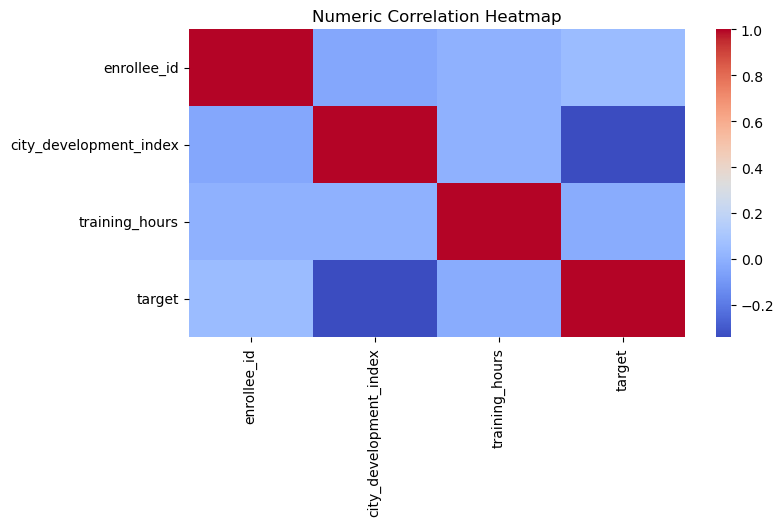

Numeric Columns: ['enrollee_id', 'city_development_index', 'training_hours', 'target']


In [17]:
#Univariate Analysis
# Heatmap of numeric columns only
num_df = train.select_dtypes(include=['int64','float64'])
plt.figure(figsize=(8,4))
sns.heatmap(num_df.corr(), cmap='coolwarm', annot=False)
plt.title("Numeric Correlation Heatmap")
plt.show()
print("Numeric Columns:", num_df.columns.tolist())

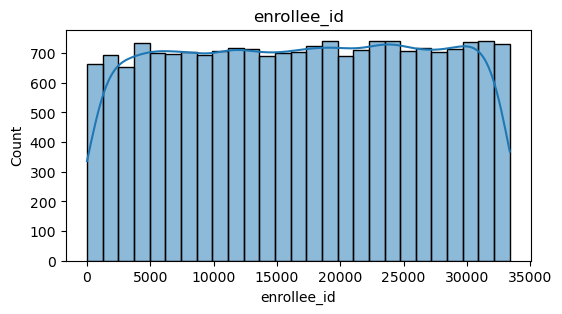

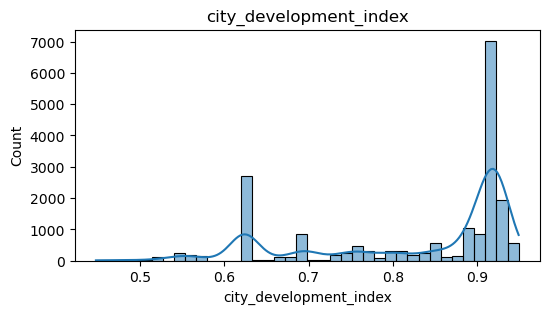

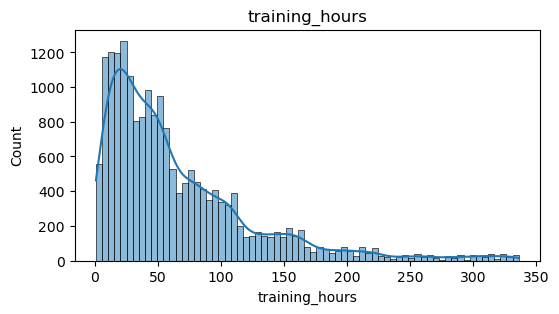

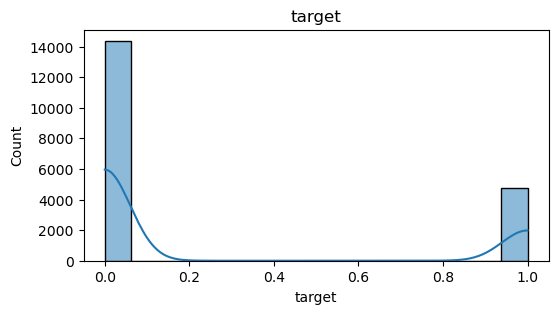

In [18]:
# Histograms for all numeric columns
numeric_cols = train.select_dtypes(include=['int64','float64']).columns

for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(train[col], kde=True)  # bars + density line
    plt.title(col)
    plt.show()


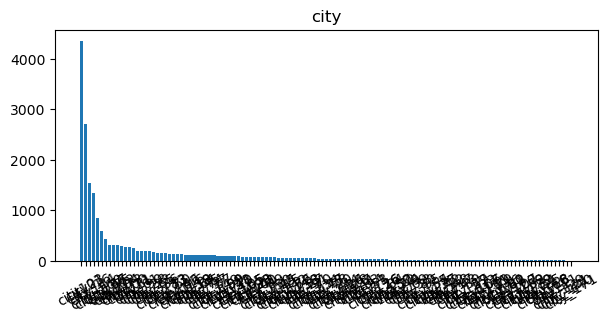

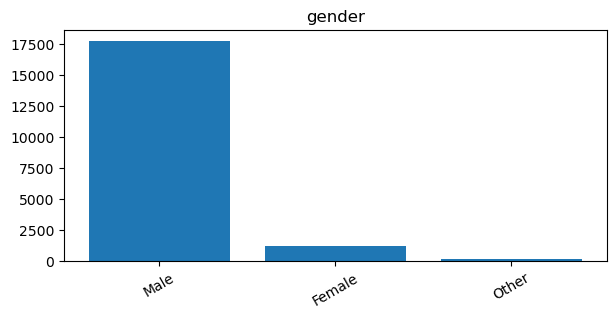

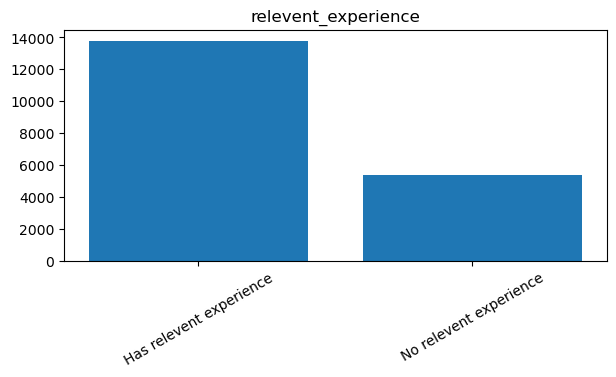

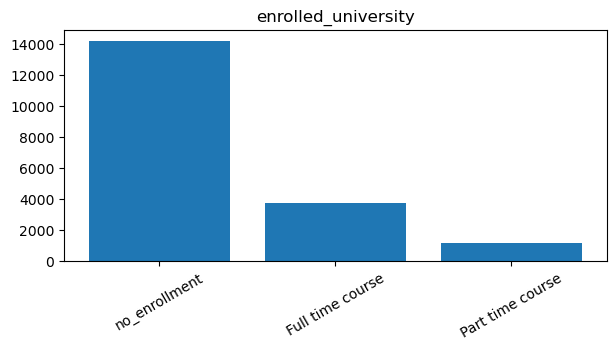

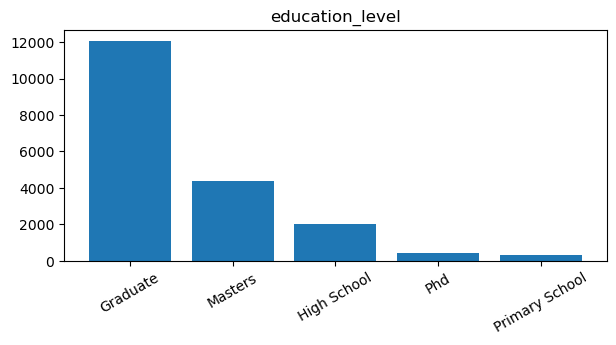

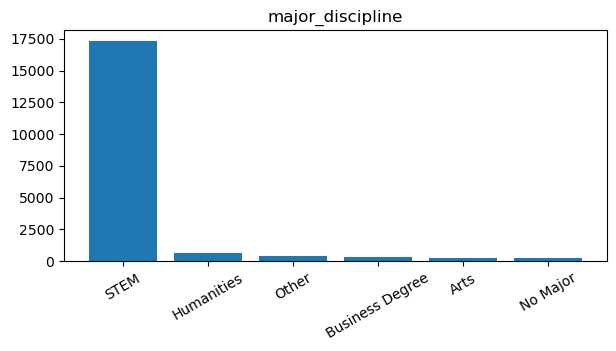

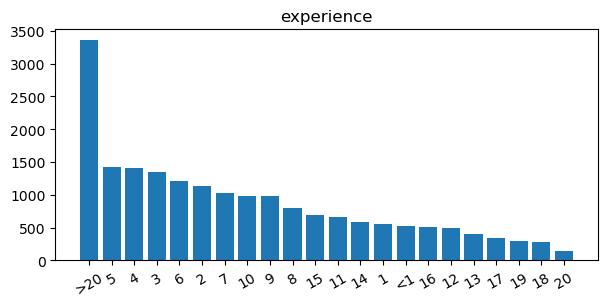

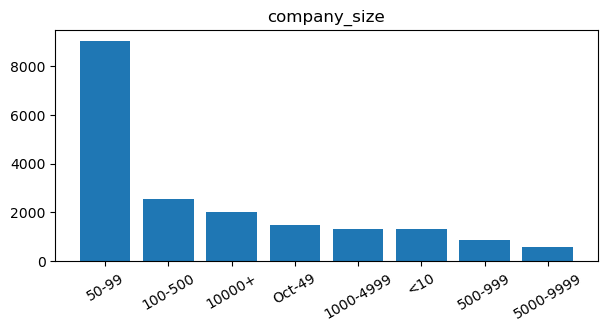

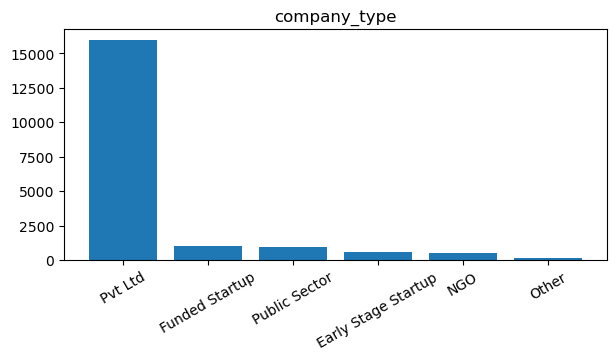

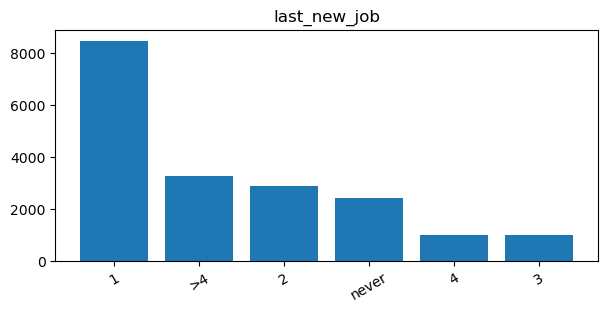

In [19]:
# Countplots for all categorical columns
categorical_cols = train.select_dtypes(include=['object','category','bool']).columns

for col in categorical_cols:
    plt.figure(figsize=(7,3))
    plt.bar(train[col].value_counts().index.astype(str), train[col].value_counts())
    plt.title(col)
    plt.xticks(rotation=30)
    plt.show()

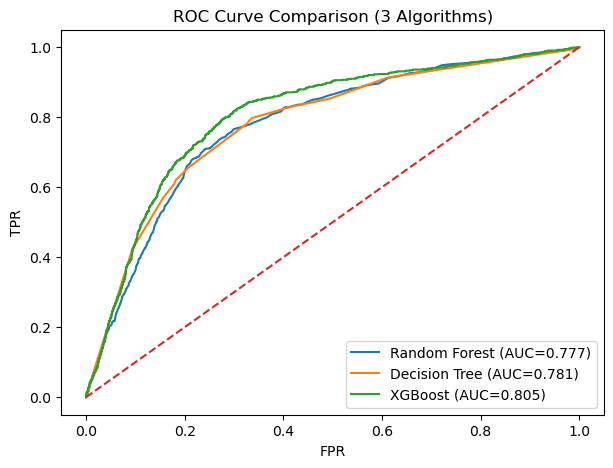

In [20]:
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre  = preprocessor.transform(X_test)

X_test_pre = preprocessor.transform(X_test)   

models = {"Random Forest": rf,
          "Decision Tree": dt,
          "XGBoost": xgb}

plt.figure(figsize=(7,5))

for name, m in models.items():
    prob = m.predict_proba(X_test_pre)[:, 1]   #use PREPROCESSED data
    fpr, tpr, _ = roc_curve(y_test, prob)
    auc = roc_auc_score(y_test, prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1],[0,1], "--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve Comparison (3 Algorithms)")
plt.legend()
plt.show()


In [21]:
print("\nModel Performance Summary:")
print("---------------------------")

models = {
    "Decision Tree" : [accuracy_score(y_test, dt_pred), roc_auc_score(y_test, dt_prob)],
    "Random Forest" : [accuracy_score(y_test, rf_pred), roc_auc_score(y_test, rf_prob)],
    "XGBoost"       : [accuracy_score(y_test, xgb_pred), roc_auc_score(y_test, xgb_prob)],
}

for m, v in models.items():
    print(f"{m} → Accuracy: {v[0]:.4f}, AUC: {v[1]:.4f}")

#Best Model- XGBoost is selected for model


Model Performance Summary:
---------------------------
Decision Tree → Accuracy: 0.7863, AUC: 0.7811
Random Forest → Accuracy: 0.7683, AUC: 0.7771
XGBoost → Accuracy: 0.7897, AUC: 0.8051


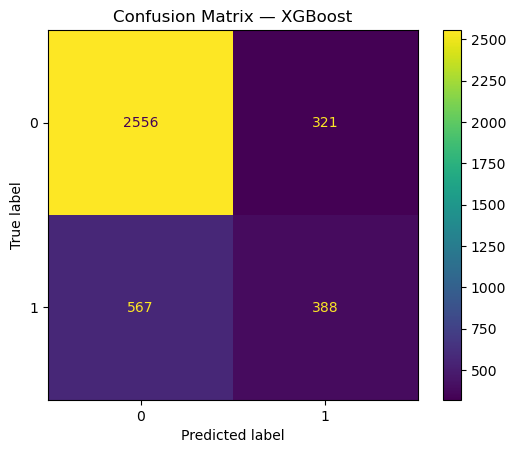

In [22]:
#Confusion Matrix display
cm = confusion_matrix(y_test, rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix — XGBoost")
plt.show()

In [23]:
#Classification report (all scores)
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      2877
           1       0.55      0.41      0.47       955

    accuracy                           0.77      3832
   macro avg       0.68      0.65      0.66      3832
weighted avg       0.75      0.77      0.76      3832



In [24]:
joblib.dump(xgb, "xgb_bestmodel.joblib")
print("✅ Model with preprocessing saved as ProjectJD.joblib")

✅ Model with preprocessing saved as ProjectJD.joblib
